In [1]:
import pandas as pd
import datetime as dt

df = pd.read_csv('OnlineRetail.csv', encoding='latin1')

# --- Initial Cleaning ---
df.dropna(subset=['CustomerID'], inplace=True)
# Remove cancelled orders 
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
# Remove rows with negative Quantity or Price
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert CustomerID to integer
df['CustomerID'] = df['CustomerID'].astype(int)
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Data cleaned successfully.")
df.info()


# Create a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Set a snapshot date for recency calculation
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by customer and calculate RFM values
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency
    'InvoiceNo': 'nunique', # Frequency
    'TotalPrice': 'sum' # Monetary
})

# Rename the columns for clarity
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                       'InvoiceNo': 'Frequency',
                       'TotalPrice': 'Monetary'}, inplace=True)

print("\nRFM Table:")
print(rfm_df.head())

Data cleaned successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  int64         
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.3+ MB

RFM Table:
            Recency  Frequency  Monetary
CustomerID                              
12346           326          1  77183.60
12347             2          7   4310.00
12348            75          4   1797.24
12349            19          1   1757.55
12350           310         

In [2]:
from sklearn.preprocessing import StandardScaler

rfm_scaled = rfm_df.copy()

scaler = StandardScaler()
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])

print("Scaled RFM Data:")
print(rfm_scaled.head())

Scaled RFM Data:
             Recency  Frequency  Monetary
CustomerID                               
12346       2.334574  -0.425097  8.358668
12347      -0.905340   0.354417  0.250966
12348      -0.175360  -0.035340 -0.028596
12349      -0.735345  -0.425097 -0.033012
12350       2.174578  -0.425097 -0.191347


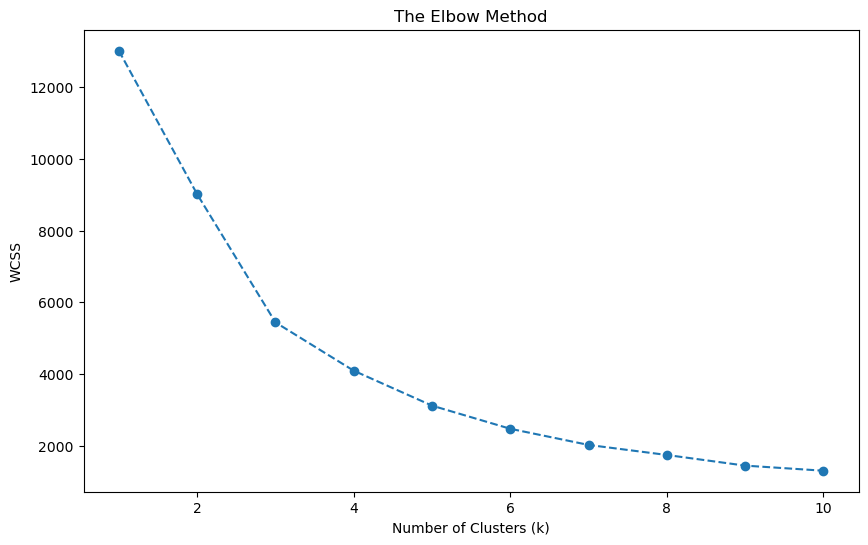

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = [] # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()

In [4]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

rfm_df['Cluster'] = kmeans.labels_

print("\nRFM Table with Cluster Labels:")
print(rfm_df.head())


RFM Table with Cluster Labels:
            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346           326          1  77183.60        3
12347             2          7   4310.00        0
12348            75          4   1797.24        0
12349            19          1   1757.55        0
12350           310          1    334.40        1


In [5]:
# Analyze the average RFM values for each cluster
segment_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print(segment_analysis)

         Recency  Frequency   Monetary
Cluster                               
0          43.70       3.68    1359.05
1         248.08       1.55     480.62
2           7.38      82.54  127338.31
3          15.50      22.33   12709.09


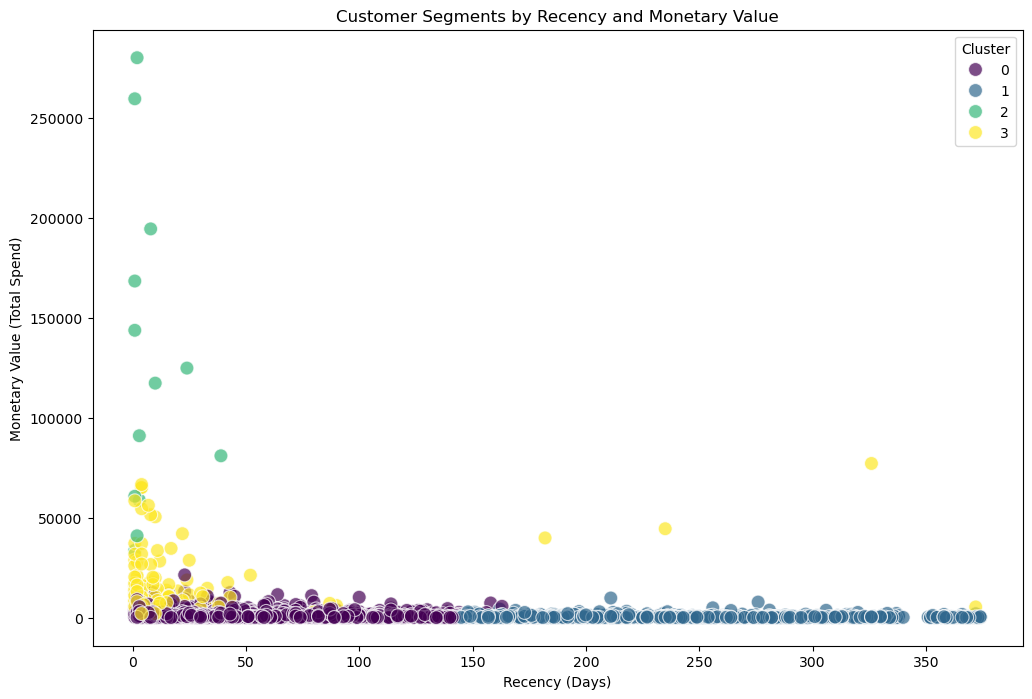

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.scatterplot(x=rfm_df['Recency'], y=rfm_df['Monetary'], hue=rfm_df['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments by Recency and Monetary Value')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary Value (Total Spend)')
plt.legend(title='Cluster')
plt.show()